# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [var_smoothing](#var_smoothing)
* [n_estimators](#n_estimators)
* [Discussion](#Discussion)

# Introduction

After rounds of feature engineering, visualization & exploration, and tuning various aspects of the classification pipeline, we are about to create our first prototype classifier using a bagged GaussianNB. In this notebook, we perform a grid search over var_smoothing using out-of-bag accuracy instead of cross validation. Fixing this var_smoothing to the best value observed, we perform a grid search for n_estimators of the bagging meta-classifier.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd
from scipy.stats import loguniform

# utility
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

# metrics
from sklearn.metrics import log_loss, roc_auc_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 2.13 s


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location of pre-final features
FEATURES_FOLDER = "../19.0-mic-extract_FRILL-based_features_from_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 97.3 ms


# Setup

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    keep_columns = [
        "id",
        "source",
        "speaker_id",
        "speaker_gender",
        "emo",
        "valence",
        "lang1",
    ]
    labels = pd.concat(
        (
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
            ),
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/nondev_labels.feather", columns=keep_columns
            ),
        )
    ).set_index("id")
    return labels


def load_data(unscaled=False) -> pd.DataFrame:
    """Loads the FRILL-based features"""
    if unscaled:
        df = pd.read_feather(
            f"{FEATURES_FOLDER}/unscaled_features_ready_for_selection.feather"
        ).set_index("id")
    else:
        df = pd.read_feather(
            f"{FEATURES_FOLDER}/features_ready_for_selection.feather"
        ).set_index("id")
    df.columns = df.columns.astype(str)
    return df


data = load_data(unscaled=True)
labels = load_labels()
y_true = labels.valence
gnb_features = ["spherical-LDA1", "spherical-LDA2"]
assert all(data.index == labels.index)
_ = gc_collect()

time: 231 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Columns: 118 entries, theta_LDA1+LDA2 to LDA-ocSVM_poly6_pos
dtypes: float64(118)
memory usage: 78.8 MB
<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   source          86752 non-null  category
 1   speaker_id      86752 non-null  category
 2   speaker_gender  86752 non-null  category
 3   emo             86752 non-null  category
 4   valence         86752 non-null  int8    
 5   lang1           86752 non-null  category
dtypes: category(5), int8(1)
memory usage: 1.3 MB
time: 23 ms


# var_smoothing

In [ ]:
df = data.loc[:, gnb_features]
results = {"var_smoothing": [], "oob_score": [], "log_loss": [], "auroc": []}
make_gnb = lambda var_smoothing: BaggingClassifier(
    base_estimator=GaussianNB(var_smoothing=var_smoothing),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    # verbose=1,
).fit(df, y_true)
for hp in tqdm(np.random.uniform(0.0, 0.3, size=300)):
    gnb = make_gnb(hp)
    results["var_smoothing"].append(hp)
    results["oob_score"].append(gnb.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := gnb.predict_proba(df), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

In [ ]:
df = pd.DataFrame(results).sort_values(by="var_smoothing", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
df.plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

df.columns = df.columns.astype(str)
df.reset_index().to_feather(
    f"{DATA_OUT_FOLDER}/var_smoothing_results_uniform_2.feather"
)

With a log uniform distribution instead of uniform

In [ ]:
df = data.loc[:, gnb_features]
results = {"var_smoothing": [], "oob_score": [], "log_loss": [], "auroc": []}
make_gnb = lambda var_smoothing: BaggingClassifier(
    base_estimator=GaussianNB(var_smoothing=var_smoothing),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    # verbose=1,
).fit(df, y_true)
for hp in tqdm(loguniform.rvs(1e-11, 0.4, size=500)):
    gnb = make_gnb(hp)
    results["var_smoothing"].append(hp)
    results["oob_score"].append(gnb.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := gnb.predict_proba(df), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(by="var_smoothing", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(
    f"{DATA_OUT_FOLDER}/var_smoothing_results_loguniform_2.feather"
)

# scale and plot
df.loc[:, "var_smoothing"] = np.log(df.loc[:, "var_smoothing"])
df.plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_feather(f"{DATA_OUT_FOLDER}/var_smoothing_results_uniform_2.feather").drop(
    "index", axis="columns"
)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
df.plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

df = pd.read_feather(
    f"{DATA_OUT_FOLDER}/var_smoothing_results_loguniform_2.feather"
).drop("index", axis="columns")
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
df.loc[:, "var_smoothing"] = np.log(df.loc[:, "var_smoothing"])
df.plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

# n_estimators

In [ ]:
df = data.loc[:, gnb_features]
results = {
    "n_estimators": [],
    "var_smoothing": [],
    "oob_score": [],
    "log_loss": [],
    "auroc": [],
}
make_gnb = lambda n_estimators, var_smoothing: BaggingClassifier(
    base_estimator=GaussianNB(var_smoothing=var_smoothing),
    n_estimators=n_estimators,
    oob_score=True,
    warm_start=False,
    n_jobs=-1,
    random_state=SEED,
)

for var_smoothing in tqdm(np.random.uniform(0.001, 0.25, size=100)):
    for n in tqdm(range(10, 41)):
        model = make_gnb(n, var_smoothing).fit(df, y_true)
        results["n_estimators"].append(n)
        results["var_smoothing"].append(var_smoothing)
        results["oob_score"].append(model.oob_score_)
        results["auroc"].append(
            roc_auc_score(y_true, y_pred := model.predict_proba(df), multi_class="ovo")
        )
        results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(
    by=["n_estimators", "var_smoothing"], ascending=True
)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/GNB2_results.feather")

In [ ]:
# plot
df.drop("var_smoothing", axis="columns").plot(x="n_estimators")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
df.drop("n_estimators", axis="columns").plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

print("unbagged scores")
plain = GaussianNB(var_smoothing=0.18).fit(_ := data.loc[:, gnb_features], y_true)
print("accuracy:", accuracy_score(y_true, plain.predict(_)))
print(
    "auroc:", roc_auc_score(y_true, y_pred := plain.predict_proba(_), multi_class="ovo")
)
print("log loss:", log_loss(y_true, y_pred))

In [ ]:
df = pd.DataFrame(results).sort_values(
    by=["n_estimators", "var_smoothing"], ascending=True
)
print(df.sort_values(by="oob_score", ascending=False).head(100))
print(df.sort_values(by="log_loss", ascending=True).head(100))

In [7]:
files = [
    "var_smoothing_results_uniform.feather",
    "var_smoothing_results_uniform_2.feather",
    "var_smoothing_results_loguniform.feather",
    "var_smoothing_results_loguniform_2.feather",
]
df = pd.concat(
    [
        pd.read_feather(f"{DATA_OUT_FOLDER}/{file}").drop("index", axis="columns")
        for file in files
    ],
    axis="rows",
)
df["n_estimators"] = 50

time: 20.5 ms


In [8]:
df_ = pd.read_feather(f"{DATA_OUT_FOLDER}/GNB_n_estimators_results.feather").drop(
    "index", axis="columns"
)
df_["var_smoothing"] = 1e-9
df = pd.concat([df, df_], axis="rows").reset_index(drop=True)

time: 11 ms


In [9]:
df = pd.concat(
    [
        df,
        pd.read_feather(f"{DATA_OUT_FOLDER}/GNB2_results.feather").drop(
            "index", axis="columns"
        ),
    ],
    axis="rows",
)

time: 6.03 ms


when n_estimators = 50 and var_smoothing = 0.0

* OOB score 0.8803601069715972
* auroc 0.9695215025075085
* log_loss 0.356045284227066

In [10]:
df.columns
_ = gc_collect()

Index(['var_smoothing', 'oob_score', 'log_loss', 'auroc', 'n_estimators'], dtype='object')

time: 118 ms


In [11]:
df.loc[len(df.index)] = [
    0.0,
    0.8803601069715972,
    0.356045284227066,
    0.9695215025075085,
    50,
]

time: 4 ms


<AxesSubplot:xlabel='n_estimators'>

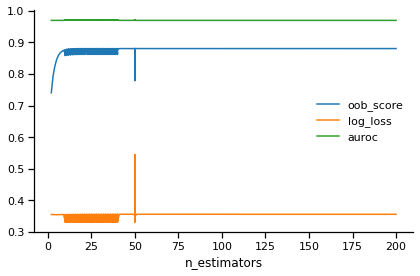

<AxesSubplot:xlabel='var_smoothing'>

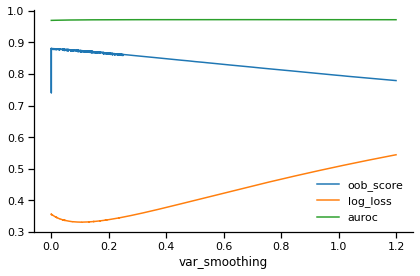

time: 705 ms


In [12]:
# plot
df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
    x="n_estimators"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
    x="var_smoothing"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='n_estimators', ylabel='auroc'>

No handles with labels found to put in legend.


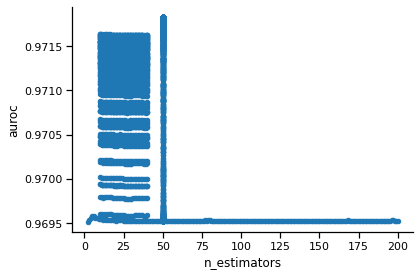

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

No handles with labels found to put in legend.


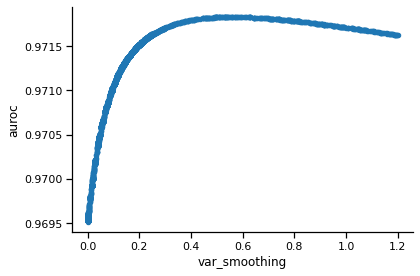

<AxesSubplot:xlabel='n_estimators', ylabel='log_loss'>

No handles with labels found to put in legend.


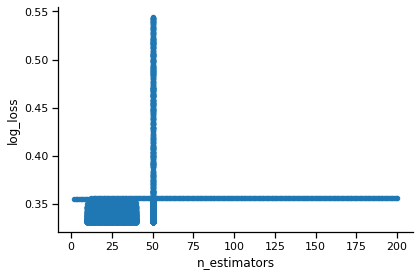

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

No handles with labels found to put in legend.


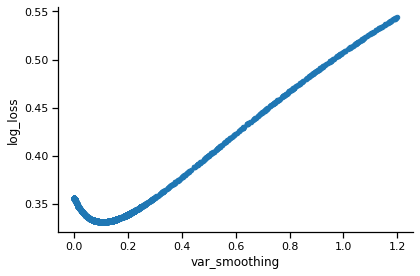

<AxesSubplot:xlabel='n_estimators', ylabel='oob_score'>

No handles with labels found to put in legend.


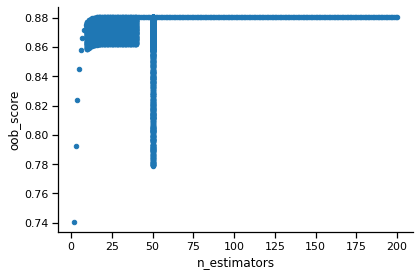

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

No handles with labels found to put in legend.


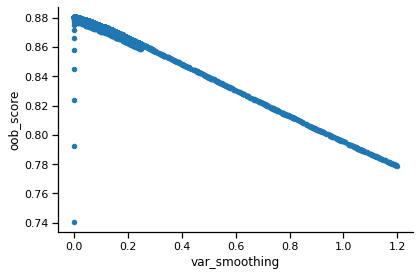

time: 1.41 s


In [13]:
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
        x="n_estimators", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()
    df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

In [14]:
# best
df.loc[df.log_loss == df.log_loss.min()]
df.loc[df.oob_score == df.oob_score.max()].sort_values(by="log_loss", ascending=True)
df.loc[df.auroc == df.auroc.max()]

,var_smoothing,oob_score,log_loss,auroc,n_estimators
33,0.104183,0.870355,0.331001,0.971094,10.0


,var_smoothing,oob_score,log_loss,auroc,n_estimators
1227,1.109113e-03,0.880429,0.355325,0.969553,50.0
1829,1.000000e-09,0.880429,0.355889,0.969524,31.0
1827,1.000000e-09,0.880429,0.355890,0.969521,29.0


,var_smoothing,oob_score,log_loss,auroc,n_estimators
225,0.55752,0.834044,0.413297,0.971828,50.0


time: 37 ms


In [15]:
# next best
df.sort_values(by="log_loss", ascending=True).head(6).tail(5)
df.sort_values(by="oob_score", ascending=False).head(10).tail(7)
df.sort_values(by="auroc", ascending=False).head(6).tail(5)

,var_smoothing,oob_score,log_loss,auroc,n_estimators
34,0.105835,0.870378,0.331003,0.971105,10.0
32,0.101252,0.870470,0.331016,0.971072,10.0
31,0.100766,0.870504,0.331021,0.971069,10.0
35,0.109706,0.870205,0.331031,0.971132,10.0
133,0.104183,0.871576,0.331070,0.971089,11.0


,var_smoothing,oob_score,log_loss,auroc,n_estimators
1687,1.169643e-03,0.880418,0.355286,0.969555,50.0
1689,1.171133e-03,0.880418,0.355285,0.969555,50.0
1824,1.000000e-09,0.880418,0.355923,0.969523,26.0
1825,1.000000e-09,0.880418,0.355954,0.969522,27.0
1826,1.000000e-09,0.880418,0.355911,0.969522,28.0
1830,1.000000e-09,0.880418,0.355878,0.969525,32.0
1688,1.170368e-03,0.880418,0.355286,0.969555,50.0


,var_smoothing,oob_score,log_loss,auroc,n_estimators
227,0.560563,0.833883,0.413990,0.971828,50.0
226,0.559919,0.833894,0.413844,0.971828,50.0
224,0.556227,0.834194,0.413002,0.971828,50.0
228,0.563101,0.833618,0.414568,0.971828,50.0
1296,0.550041,0.834874,0.411592,0.971828,50.0


time: 33 ms


<AxesSubplot:xlabel='n_estimators'>

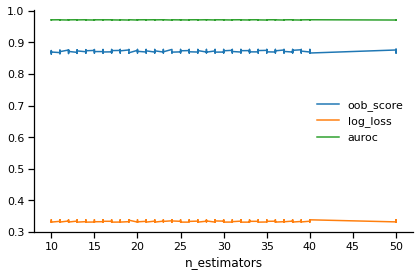

<AxesSubplot:xlabel='var_smoothing'>

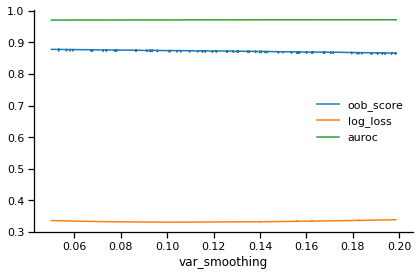

<AxesSubplot:xlabel='n_estimators', ylabel='auroc'>

No handles with labels found to put in legend.


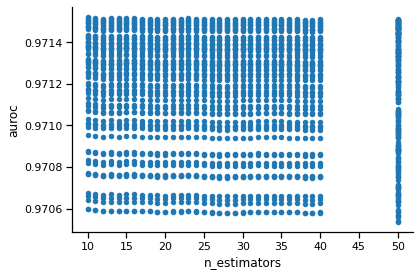

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

No handles with labels found to put in legend.


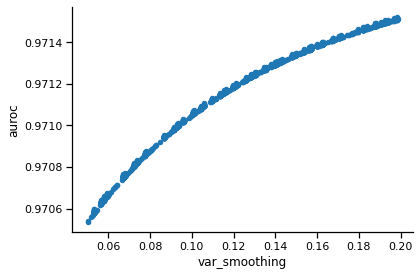

<AxesSubplot:xlabel='n_estimators', ylabel='log_loss'>

No handles with labels found to put in legend.


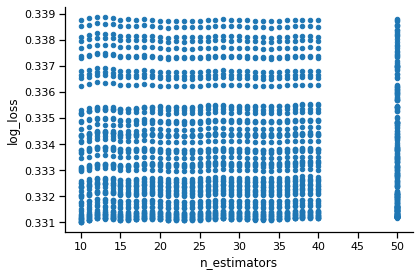

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

No handles with labels found to put in legend.


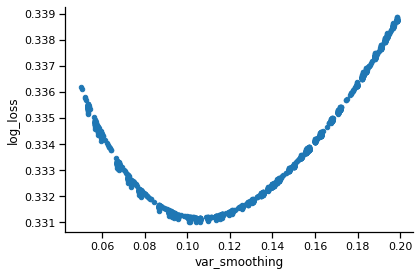

<AxesSubplot:xlabel='n_estimators', ylabel='oob_score'>

No handles with labels found to put in legend.


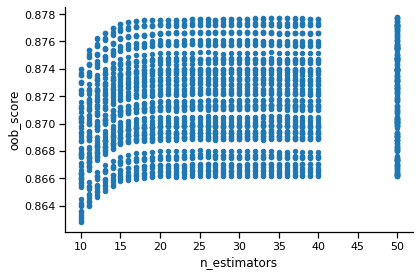

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

No handles with labels found to put in legend.


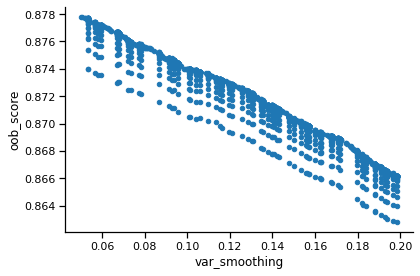

time: 1.93 s


In [16]:
good_df = df.loc[df.var_smoothing > 0.05]
good_df = good_df.loc[good_df.var_smoothing < 0.2]
good_df = good_df.loc[good_df.n_estimators >= 10]

# plot
good_df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
    x="n_estimators"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
good_df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
    x="var_smoothing"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    good_df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
        x="n_estimators", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()
    good_df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

<AxesSubplot:xlabel='n_estimators'>

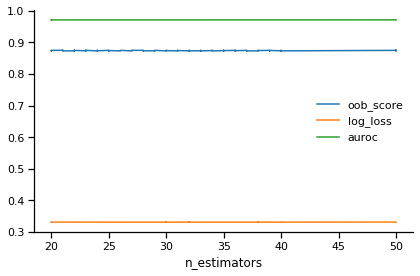

<AxesSubplot:xlabel='var_smoothing'>

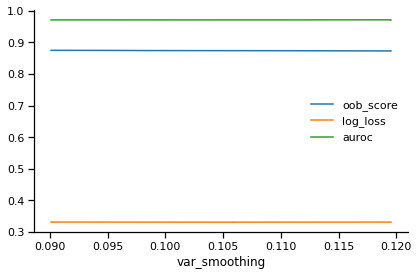

<AxesSubplot:xlabel='n_estimators', ylabel='auroc'>

No handles with labels found to put in legend.


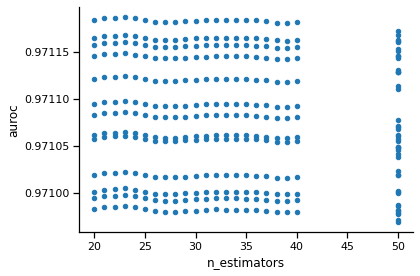

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

No handles with labels found to put in legend.


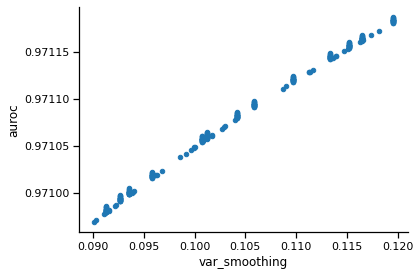

<AxesSubplot:xlabel='n_estimators', ylabel='log_loss'>

No handles with labels found to put in legend.


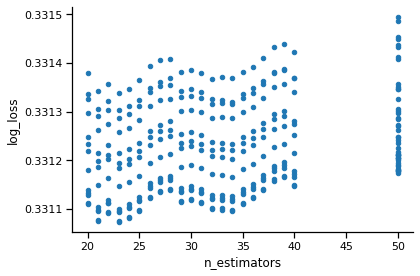

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

No handles with labels found to put in legend.


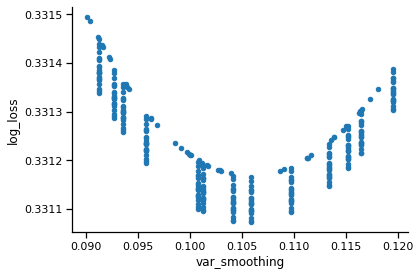

<AxesSubplot:xlabel='n_estimators', ylabel='oob_score'>

No handles with labels found to put in legend.


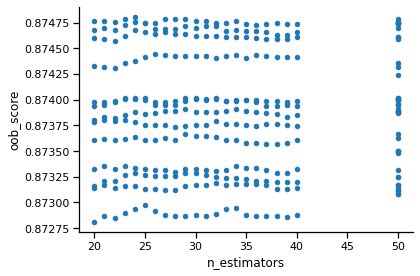

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

No handles with labels found to put in legend.


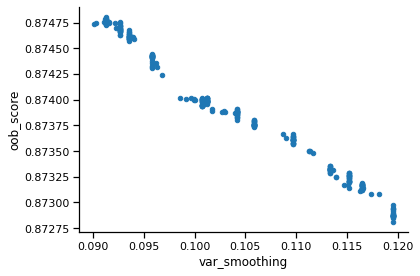

time: 1.58 s


In [17]:
good_df = df.loc[df.var_smoothing > 0.09]
good_df = good_df.loc[good_df.var_smoothing < 0.12]
good_df = good_df.loc[good_df.n_estimators >= 20]

# plot
good_df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
    x="n_estimators"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
good_df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
    x="var_smoothing"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    good_df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
        x="n_estimators", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()
    good_df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

<AxesSubplot:xlabel='n_estimators'>

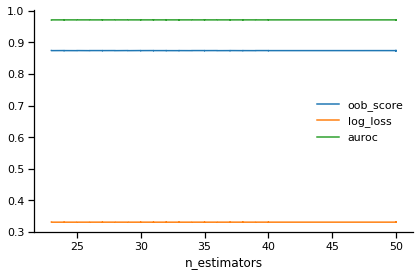

<AxesSubplot:xlabel='var_smoothing'>

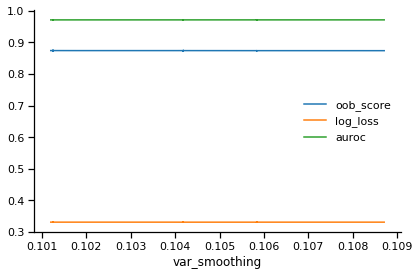

<AxesSubplot:xlabel='n_estimators', ylabel='auroc'>

No handles with labels found to put in legend.


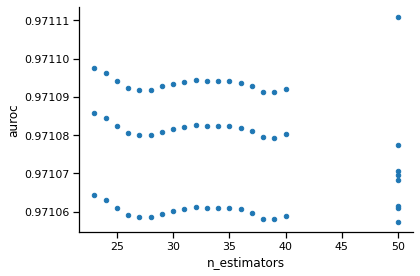

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

No handles with labels found to put in legend.


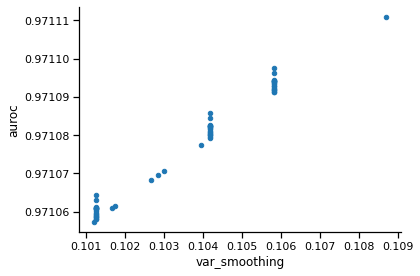

<AxesSubplot:xlabel='n_estimators', ylabel='log_loss'>

No handles with labels found to put in legend.


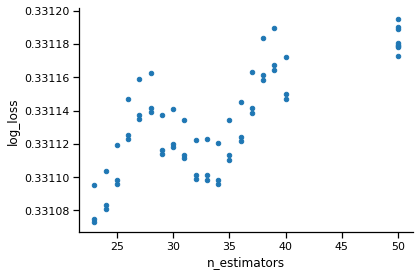

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

No handles with labels found to put in legend.


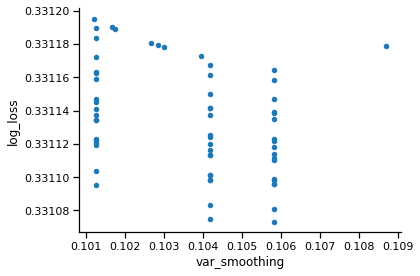

<AxesSubplot:xlabel='n_estimators', ylabel='oob_score'>

No handles with labels found to put in legend.


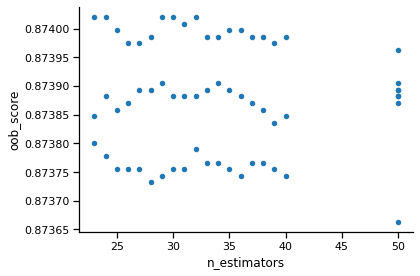

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

No handles with labels found to put in legend.


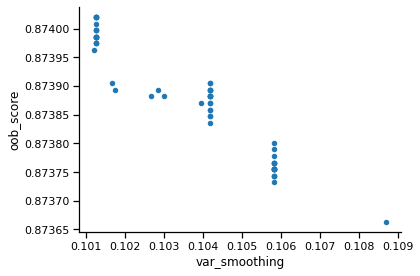

time: 1.61 s


In [18]:
good_df = df.loc[df.var_smoothing > 0.101]
good_df = good_df.loc[good_df.var_smoothing < 0.109]
good_df = good_df.loc[good_df.n_estimators >= 23]

# plot
good_df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
    x="n_estimators"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
good_df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
    x="var_smoothing"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    good_df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
        x="n_estimators", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()
    good_df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

<AxesSubplot:xlabel='n_estimators'>

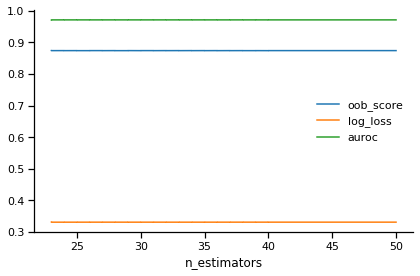

<AxesSubplot:xlabel='var_smoothing'>

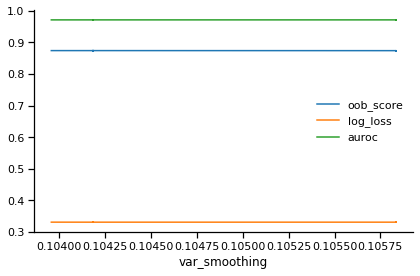

<AxesSubplot:xlabel='n_estimators', ylabel='auroc'>

No handles with labels found to put in legend.


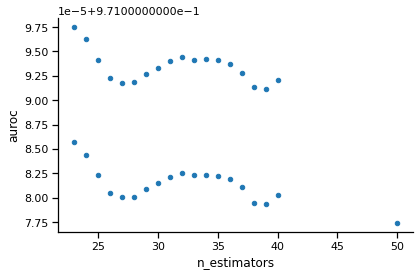

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

No handles with labels found to put in legend.


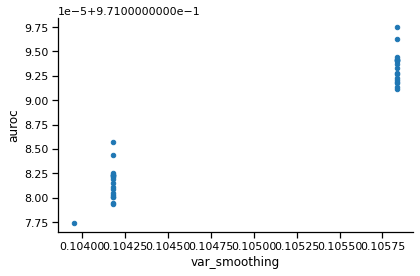

<AxesSubplot:xlabel='n_estimators', ylabel='log_loss'>

No handles with labels found to put in legend.


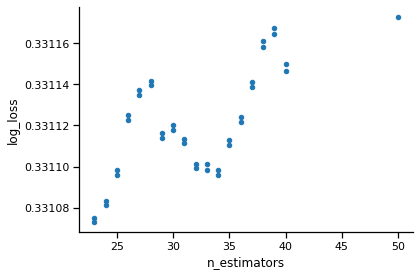

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

No handles with labels found to put in legend.


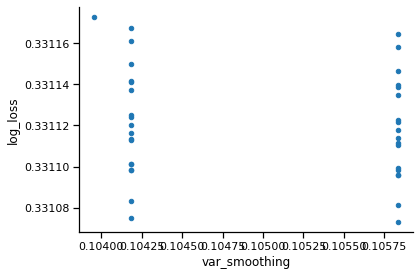

<AxesSubplot:xlabel='n_estimators', ylabel='oob_score'>

No handles with labels found to put in legend.


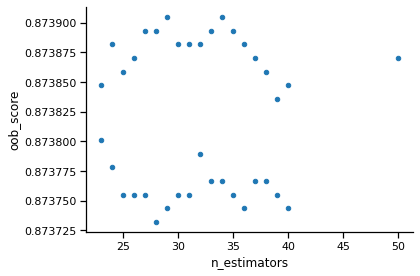

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

No handles with labels found to put in legend.


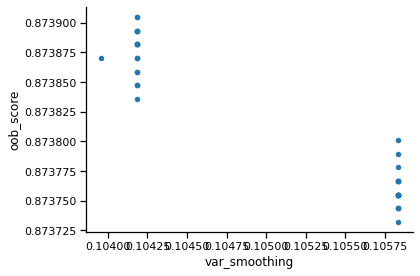

time: 1.81 s


In [19]:
good_df = df.loc[df.var_smoothing > 0.103]
good_df = good_df.loc[good_df.var_smoothing < 0.108]
good_df = good_df.loc[good_df.n_estimators >= 23]

# plot
good_df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
    x="n_estimators"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
good_df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
    x="var_smoothing"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    good_df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
        x="n_estimators", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()
    good_df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

In [20]:
df = data.loc[:, gnb_features]
results = {
    "n_estimators": [],
    "var_smoothing": [],
    "oob_score": [],
    "log_loss": [],
    "auroc": [],
}
make_gnb = lambda n_estimators, var_smoothing: BaggingClassifier(
    base_estimator=GaussianNB(var_smoothing=var_smoothing),
    n_estimators=n_estimators,
    oob_score=True,
    warm_start=False,
    n_jobs=-1,
    random_state=SEED,
)

for var_smoothing in tqdm(np.random.uniform(0.103, 0.109, size=10)):
    for n in tqdm(list(range(1, 10)) + list(range(20, 36))):
        model = make_gnb(n, var_smoothing).fit(df, y_true)
        results["n_estimators"].append(n)
        results["var_smoothing"].append(var_smoothing)
        results["oob_score"].append(model.oob_score_)
        results["auroc"].append(
            roc_auc_score(y_true, y_pred := model.predict_proba(df), multi_class="ovo")
        )
        results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(
    by=["n_estimators", "var_smoothing"], ascending=True
)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/GNB2_results_2.feather")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

     n_estimators  var_smoothing  oob_score  log_loss     auroc
142            28       0.103769   0.873928  0.331143  0.971077
67             28       0.103834   0.873928  0.331143  0.971078
66             27       0.103834   0.873916  0.331139  0.971077
140            26       0.103769   0.873916  0.331127  0.971077
74             35       0.103834   0.873916  0.331115  0.971080
173            34       0.104074   0.873916  0.331099  0.971082
139            25       0.103769   0.873916  0.331100  0.971079
168            29       0.104074   0.873916  0.331117  0.971080
141            27       0.103769   0.873916  0.331139  0.971077
65             26       0.103834   0.873905  0.331127  0.971078
     n_estimators  var_smoothing  oob_score  log_loss     auroc
150             1       0.104074   0.657610  0.330527  0.971094
75              1       0.104876   0.657553  0.330527  0.971100
50              1       0.103834   0.657645  0.330527  0.971092
125             1       0.103769   0.657

In [21]:
files = [
    "var_smoothing_results_uniform.feather",
    "var_smoothing_results_uniform_2.feather",
    "var_smoothing_results_loguniform.feather",
    "var_smoothing_results_loguniform_2.feather",
]
df = pd.concat(
    [
        pd.read_feather(f"{DATA_OUT_FOLDER}/{file}").drop("index", axis="columns")
        for file in files
    ],
    axis="rows",
)
df["n_estimators"] = 50

time: 18 ms


In [22]:
df_ = pd.read_feather(f"{DATA_OUT_FOLDER}/GNB_n_estimators_results.feather").drop(
    "index", axis="columns"
)
df_["var_smoothing"] = 1e-9
df = pd.concat([df, df_], axis="rows").reset_index(drop=True)
del df_
_ = gc_collect()

time: 228 ms


In [23]:
df = pd.concat(
    [
        df,
        pd.read_feather(f"{DATA_OUT_FOLDER}/GNB2_results.feather").drop(
            "index", axis="columns"
        ),
    ],
    axis="rows",
)

time: 9.01 ms


In [24]:
df = pd.concat(
    [
        df,
        pd.read_feather(f"{DATA_OUT_FOLDER}/GNB2_results_2.feather").drop(
            "index", axis="columns"
        ),
    ],
    axis="rows",
)

time: 19.2 ms


In [25]:
df.loc[len(df.index)] = [
    0.0,
    0.8803601069715972,
    0.356045284227066,
    0.9695215025075085,
    50,
]

time: 7 ms


<AxesSubplot:xlabel='n_estimators', ylabel='auroc'>

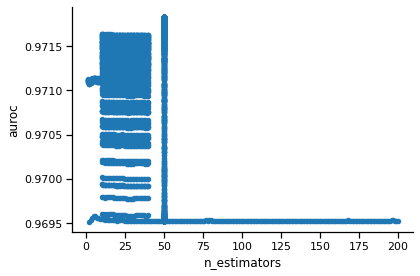

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

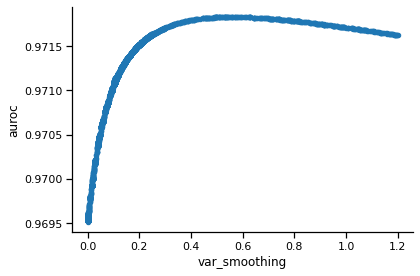

<AxesSubplot:xlabel='n_estimators', ylabel='log_loss'>

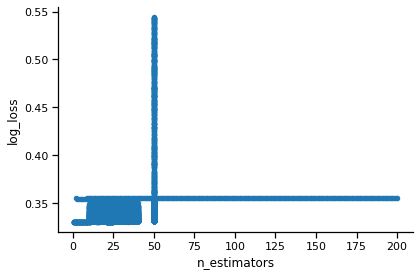

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

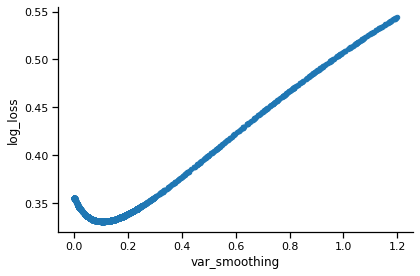

<AxesSubplot:xlabel='n_estimators', ylabel='oob_score'>

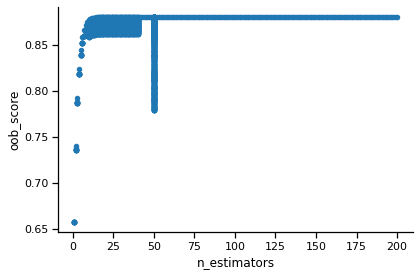

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

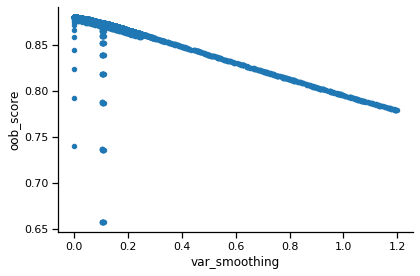

time: 1.86 s


In [26]:
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
        x="n_estimators", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()
    df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

<AxesSubplot:xlabel='n_estimators'>

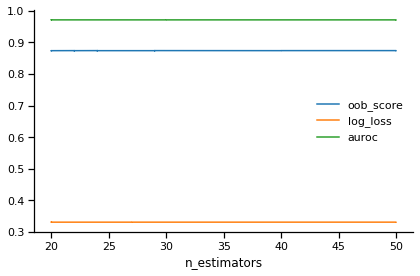

<AxesSubplot:xlabel='var_smoothing'>

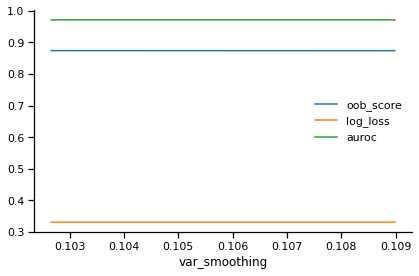

<AxesSubplot:xlabel='n_estimators', ylabel='auroc'>

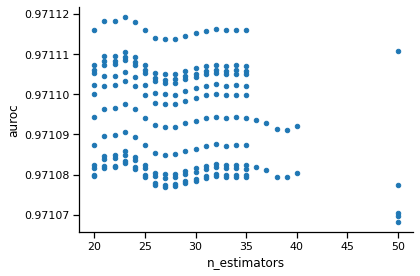

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

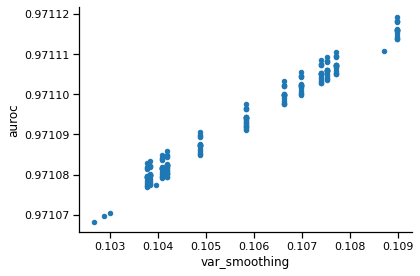

<AxesSubplot:xlabel='n_estimators', ylabel='log_loss'>

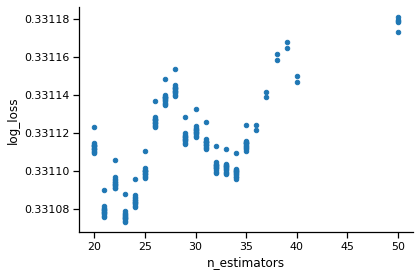

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

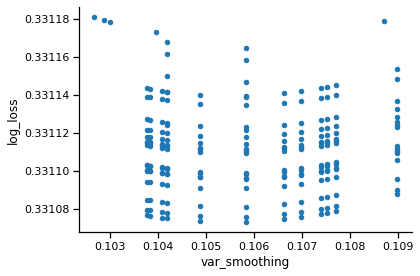

<AxesSubplot:xlabel='n_estimators', ylabel='oob_score'>

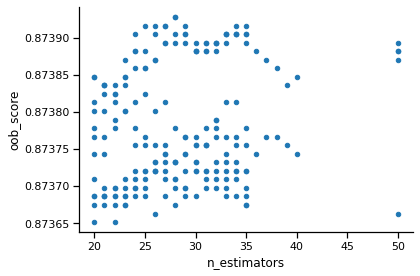

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

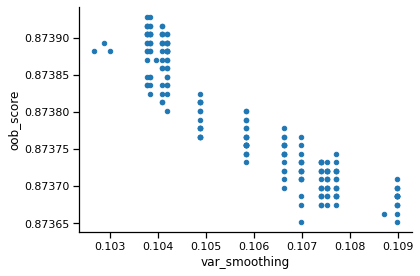

time: 1.79 s


In [27]:
good_df = df.loc[df.var_smoothing > 0.102]
good_df = good_df.loc[good_df.var_smoothing < 0.109]
good_df = good_df.loc[good_df.n_estimators >= 20]

# plot
good_df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
    x="n_estimators"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
good_df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
    x="var_smoothing"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    good_df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
        x="n_estimators", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()
    good_df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

In [28]:
df = data.loc[:, gnb_features]
results = {
    "n_estimators": [],
    "var_smoothing": [],
    "oob_score": [],
    "log_loss": [],
    "auroc": [],
}
make_gnb = lambda n_estimators, var_smoothing: BaggingClassifier(
    base_estimator=GaussianNB(var_smoothing=var_smoothing),
    n_estimators=n_estimators,
    oob_score=True,
    warm_start=False,
    n_jobs=-1,
    random_state=SEED,
)

for var_smoothing in tqdm(np.random.uniform(0.104, 0.1089, size=10)):
    for n in tqdm(range(21, 29)):
        model = make_gnb(n, var_smoothing).fit(df, y_true)
        results["n_estimators"].append(n)
        results["var_smoothing"].append(var_smoothing)
        results["oob_score"].append(model.oob_score_)
        results["auroc"].append(
            roc_auc_score(y_true, y_pred := model.predict_proba(df), multi_class="ovo")
        )
        results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(
    by=["n_estimators", "var_smoothing"], ascending=True
)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="auroc", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/GNB2_results_3.feather")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

    n_estimators  var_smoothing  oob_score  log_loss     auroc
14            27       0.104287   0.873905  0.331137  0.971081
13            26       0.104287   0.873893  0.331125  0.971081
37            26       0.104424   0.873882  0.331124  0.971082
11            24       0.104287   0.873882  0.331083  0.971085
35            24       0.104424   0.873870  0.331082  0.971086
3             24       0.104475   0.873870  0.331082  0.971086
5             26       0.104475   0.873870  0.331124  0.971083
12            25       0.104287   0.873870  0.331098  0.971083
38            27       0.104424   0.873870  0.331136  0.971082
4             25       0.104475   0.873859  0.331097  0.971084
    n_estimators  var_smoothing  oob_score  log_loss     auroc
58            23       0.108723   0.873674  0.331086  0.971118
18            23       0.108716   0.873686  0.331086  0.971117
57            22       0.108723   0.873651  0.331103  0.971117
17            22       0.108716   0.873651  0.331103  0

In [32]:
files = [
    "var_smoothing_results_uniform.feather",
    "var_smoothing_results_uniform_2.feather",
    "var_smoothing_results_loguniform.feather",
    "var_smoothing_results_loguniform_2.feather",
]
df = pd.concat(
    [
        pd.read_feather(f"{DATA_OUT_FOLDER}/{file}").drop("index", axis="columns")
        for file in files
    ],
    axis="rows",
)
df["n_estimators"] = 50

time: 22.2 ms


In [33]:
df_ = pd.read_feather(f"{DATA_OUT_FOLDER}/GNB_n_estimators_results.feather").drop(
    "index", axis="columns"
)
df_["var_smoothing"] = 1e-9
df = pd.concat([df, df_], axis="rows").reset_index(drop=True)
del df_
_ = gc_collect()

time: 171 ms


In [34]:
df = pd.concat(
    [
        df,
        pd.read_feather(f"{DATA_OUT_FOLDER}/GNB2_results.feather").drop(
            "index", axis="columns"
        ),
    ],
    axis="rows",
)
_ = gc_collect()

time: 152 ms


In [35]:
df = pd.concat(
    [
        df,
        pd.read_feather(f"{DATA_OUT_FOLDER}/GNB2_results_2.feather").drop(
            "index", axis="columns"
        ),
    ],
    axis="rows",
)

time: 10 ms


In [36]:
df = pd.concat(
    [
        df,
        pd.read_feather(f"{DATA_OUT_FOLDER}/GNB2_results_3.feather").drop(
            "index", axis="columns"
        ),
    ],
    axis="rows",
)

time: 9 ms


In [37]:
df.loc[len(df.index)] = [
    0.0,
    0.8803601069715972,
    0.356045284227066,
    0.9695215025075085,
    50,
]

time: 3.97 ms


<AxesSubplot:xlabel='n_estimators', ylabel='auroc'>

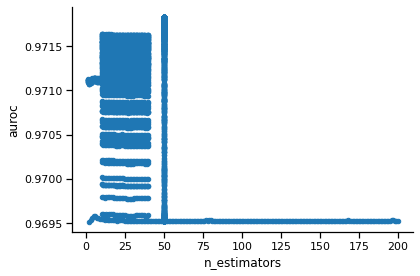

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

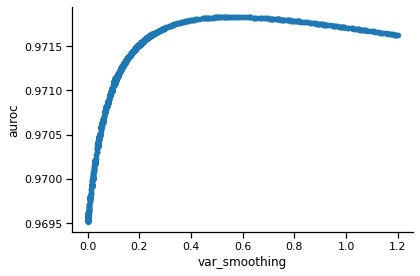

<AxesSubplot:xlabel='n_estimators', ylabel='log_loss'>

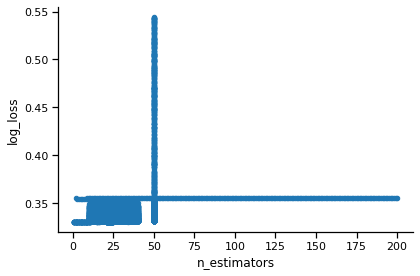

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

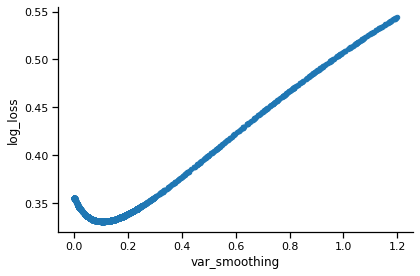

<AxesSubplot:xlabel='n_estimators', ylabel='oob_score'>

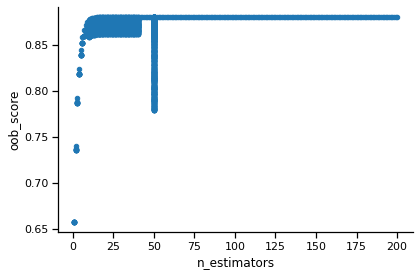

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

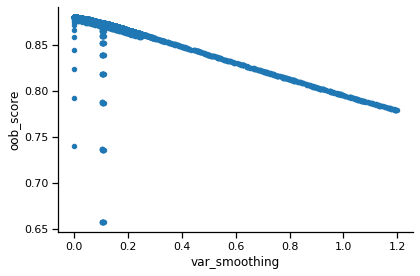

time: 1.61 s


In [38]:
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
        x="n_estimators", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()
    df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

<AxesSubplot:xlabel='n_estimators'>

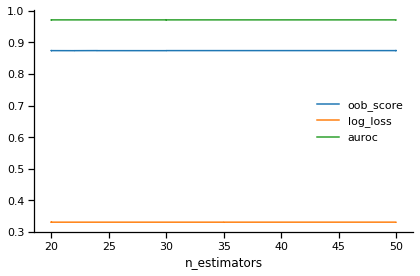

<AxesSubplot:xlabel='var_smoothing'>

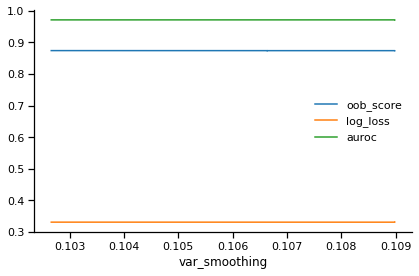

<AxesSubplot:xlabel='n_estimators', ylabel='auroc'>

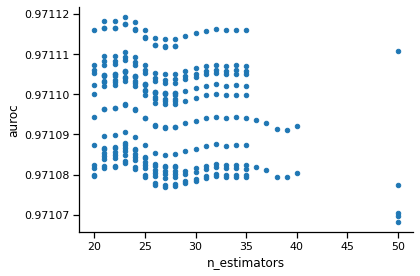

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

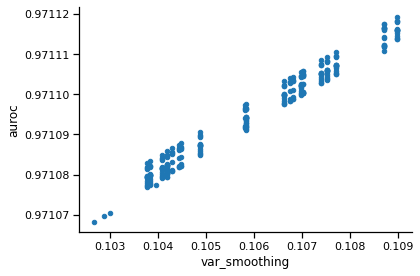

<AxesSubplot:xlabel='n_estimators', ylabel='log_loss'>

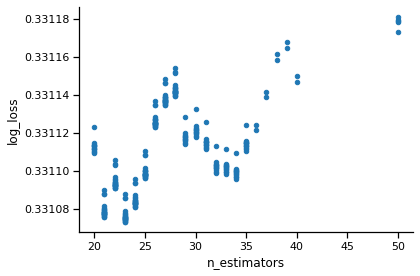

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

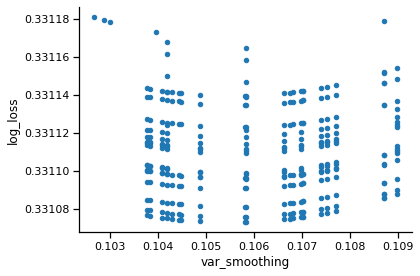

<AxesSubplot:xlabel='n_estimators', ylabel='oob_score'>

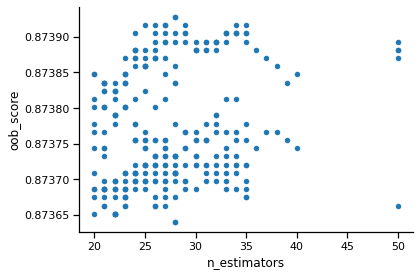

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

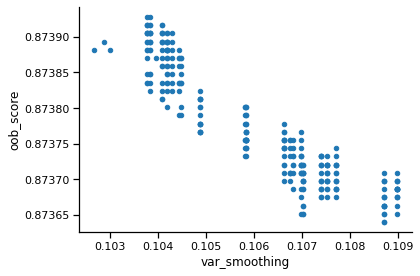

time: 1.94 s


In [39]:
good_df = df.loc[df.var_smoothing > 0.102]
good_df = good_df.loc[good_df.var_smoothing < 0.109]
good_df = good_df.loc[good_df.n_estimators >= 20]

# plot
good_df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
    x="n_estimators"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
good_df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
    x="var_smoothing"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    good_df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
        x="n_estimators", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()
    good_df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

In [40]:
df = data.loc[:, gnb_features]
results = {
    "n_estimators": [],
    "var_smoothing": [],
    "oob_score": [],
    "log_loss": [],
    "auroc": [],
}
make_gnb = lambda n_estimators, var_smoothing: BaggingClassifier(
    base_estimator=GaussianNB(var_smoothing=var_smoothing),
    n_estimators=n_estimators,
    oob_score=True,
    warm_start=False,
    n_jobs=-1,
    random_state=SEED,
)

for var_smoothing in tqdm(np.random.uniform(0.1031, 0.106, size=10)):
    for n in tqdm(range(20, 26)):
        model = make_gnb(n, var_smoothing).fit(df, y_true)
        results["n_estimators"].append(n)
        results["var_smoothing"].append(var_smoothing)
        results["oob_score"].append(model.oob_score_)
        results["auroc"].append(
            roc_auc_score(y_true, y_pred := model.predict_proba(df), multi_class="ovo")
        )
        results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(
    by=["n_estimators", "var_smoothing"], ascending=True
)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="auroc", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/GNB2_results_4.feather")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

    n_estimators  var_smoothing  oob_score  log_loss     auroc
59            25       0.103300   0.873940  0.331102  0.971076
11            25       0.103685   0.873916  0.331100  0.971079
23            25       0.103666   0.873916  0.331100  0.971079
10            24       0.103685   0.873916  0.331085  0.971081
22            24       0.103666   0.873916  0.331085  0.971081
58            24       0.103300   0.873916  0.331087  0.971078
54            20       0.103300   0.873882  0.331116  0.971076
21            23       0.103666   0.873870  0.331077  0.971082
4             24       0.104411   0.873870  0.331083  0.971086
9             23       0.103685   0.873870  0.331077  0.971082
    n_estimators  var_smoothing  oob_score  log_loss     auroc
45            23       0.105487   0.873755  0.331073  0.971095
44            22       0.105487   0.873767  0.331091  0.971094
43            21       0.105487   0.873767  0.331076  0.971094
46            24       0.105487   0.873744  0.331081  0

In [41]:
files = [
    "var_smoothing_results_uniform.feather",
    "var_smoothing_results_uniform_2.feather",
    "var_smoothing_results_loguniform.feather",
    "var_smoothing_results_loguniform_2.feather",
]
df = pd.concat(
    [
        pd.read_feather(f"{DATA_OUT_FOLDER}/{file}").drop("index", axis="columns")
        for file in files
    ],
    axis="rows",
)
df["n_estimators"] = 50

time: 23 ms


In [42]:
df_ = pd.read_feather(f"{DATA_OUT_FOLDER}/GNB_n_estimators_results.feather").drop(
    "index", axis="columns"
)
df_["var_smoothing"] = 1e-9
df = pd.concat([df, df_], axis="rows").reset_index(drop=True)
del df_
_ = gc_collect()

time: 164 ms


In [43]:
df = pd.concat(
    [
        df,
        pd.read_feather(f"{DATA_OUT_FOLDER}/GNB2_results.feather").drop(
            "index", axis="columns"
        ),
    ],
    axis="rows",
)
_ = gc_collect()

time: 152 ms


In [44]:
df = pd.concat(
    [
        df,
        pd.read_feather(f"{DATA_OUT_FOLDER}/GNB2_results_2.feather").drop(
            "index", axis="columns"
        ),
    ],
    axis="rows",
)

time: 8.99 ms


In [45]:
df = pd.concat(
    [
        df,
        pd.read_feather(f"{DATA_OUT_FOLDER}/GNB2_results_3.feather").drop(
            "index", axis="columns"
        ),
        pd.read_feather(f"{DATA_OUT_FOLDER}/GNB2_results_4.feather").drop(
            "index", axis="columns"
        ),
    ],
    axis="rows",
)

time: 14 ms


In [46]:
df.loc[len(df.index)] = [
    0.0,
    0.8803601069715972,
    0.356045284227066,
    0.9695215025075085,
    50,
]

time: 6 ms


<AxesSubplot:xlabel='n_estimators', ylabel='auroc'>

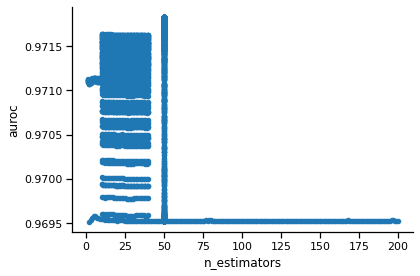

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

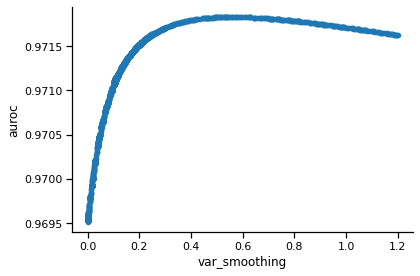

<AxesSubplot:xlabel='n_estimators', ylabel='log_loss'>

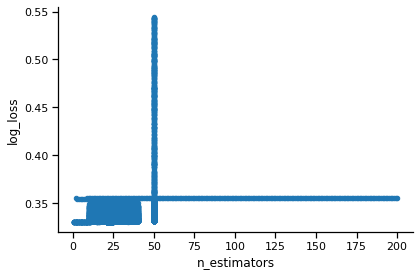

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

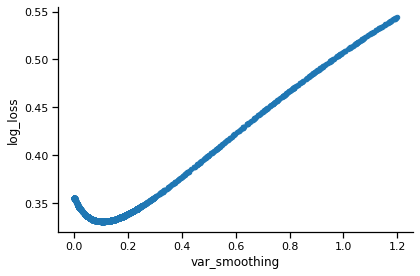

<AxesSubplot:xlabel='n_estimators', ylabel='oob_score'>

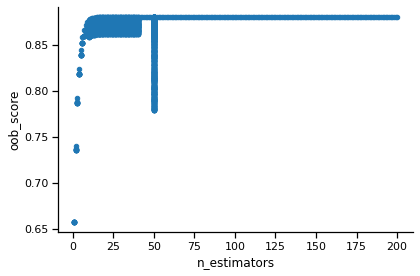

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

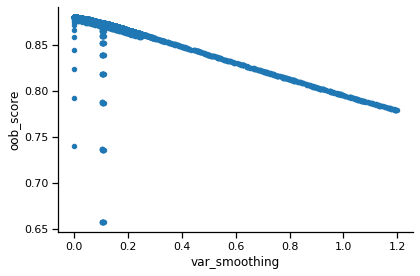

time: 1.8 s


In [47]:
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
        x="n_estimators", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()
    df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

<AxesSubplot:xlabel='n_estimators'>

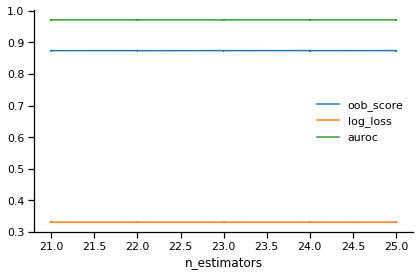

<AxesSubplot:xlabel='var_smoothing'>

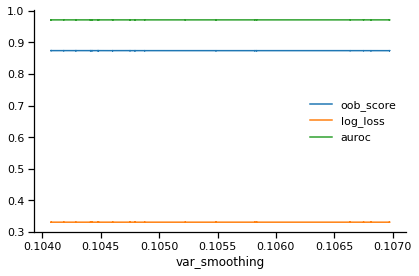

<AxesSubplot:xlabel='n_estimators', ylabel='auroc'>

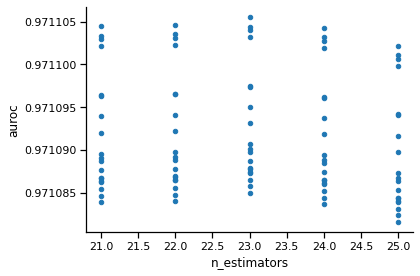

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

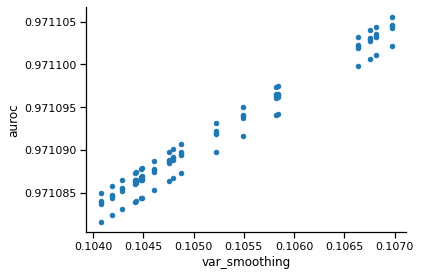

<AxesSubplot:xlabel='n_estimators', ylabel='log_loss'>

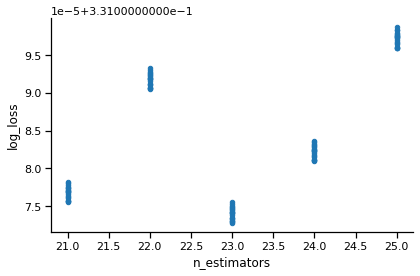

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

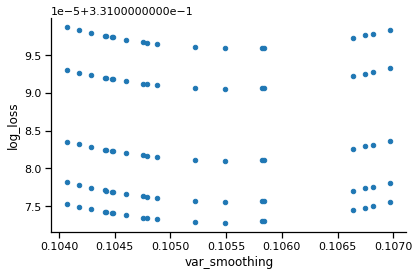

<AxesSubplot:xlabel='n_estimators', ylabel='oob_score'>

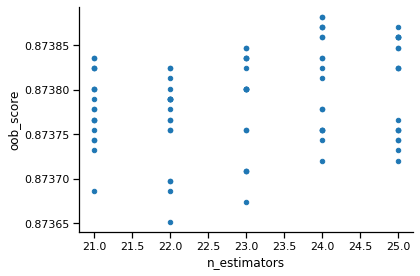

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

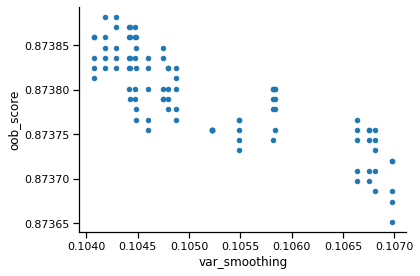

time: 1.68 s


In [56]:
good_df = df.loc[df.var_smoothing >= 0.104]
good_df = good_df.loc[good_df.var_smoothing <= 0.107]
good_df = good_df.loc[good_df.n_estimators >= 21]
good_df = good_df.loc[good_df.n_estimators <= 25]

# plot
good_df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
    x="n_estimators"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
good_df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
    x="var_smoothing"
)
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    good_df.drop("var_smoothing", axis="columns").sort_values(by="n_estimators").plot(
        x="n_estimators", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()
    good_df.drop("n_estimators", axis="columns").sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

In [57]:
# better best
good_df.loc[good_df.log_loss == good_df.log_loss.min()]
good_df.loc[good_df.oob_score == good_df.oob_score.max()]
good_df.loc[good_df.auroc == good_df.auroc.max()]

,var_smoothing,oob_score,log_loss,auroc,n_estimators
39,0.105487,0.873755,0.331073,0.971095,23.0


,var_smoothing,oob_score,log_loss,auroc,n_estimators
1433,0.104183,0.873882,0.331083,0.971084,24.0
30,0.104287,0.873882,0.331083,0.971085,24.0


,var_smoothing,oob_score,log_loss,auroc,n_estimators
125,0.106973,0.873674,0.331076,0.971106,23.0


time: 31.9 ms


In [62]:
top3 = pd.concat(
    [
        good_df.loc[good_df.log_loss == good_df.log_loss.min()],
        pd.DataFrame(
            good_df.loc[good_df.oob_score == good_df.oob_score.max()].mean()
        ).T,
        good_df.loc[good_df.auroc == good_df.auroc.max()],
    ],
    axis="rows",
).mean()
top3

var_smoothing     0.105565
oob_score         0.873770
log_loss          0.331077
auroc             0.971095
n_estimators     23.333333
dtype: float64

time: 15.1 ms


In [63]:
final_gnb = make_gnb(23, top3.var_smoothing)
_ = gc_collect()

time: 148 ms


In [64]:
final_gnb.fit(data.loc[:, gnb_features], labels.valence)

BaggingClassifier(base_estimator=GaussianNB(var_smoothing=0.10556503264086932),
                  n_estimators=23, n_jobs=-1, oob_score=True,
                  random_state=2021)

time: 2.99 s


In [65]:
final_gnb.oob_score_
log_loss(y_true, final_gnb.predict_proba(data.loc[:, gnb_features]))
roc_auc_score(
    y_true, final_gnb.predict_proba(data.loc[:, gnb_features]), multi_class="ovo"
)

0.8737665990409443

0.3310728538277503

0.971095547886979

time: 925 ms


In [66]:
23
top3.var_smoothing

23

0.10556503264086932

time: 1.06 ms


# Discussion

`var_smoothing` doesn't appear to be an important hyperparameter in this situation, although there looks to be a sweet spot in training loss. Performance appears to cap at `n_estimators = 45`.

var_smoothing around 0.185 with n_estimators at 10 seems to yield the lowest loss. 30-50 estimators with var_smoothing between 0.002 and 0.015 seems to yield the best oob accuracy.

We use the sweet spot for var_smoothing vs. log loss to hone in on the best number of estimators.

There are so many more possibilities for feature engineering. Upstream augmentation of the raw audio would probably be helpful as would resampling.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are only deviating slightly from the feature engineering pathway we already established.

In [ ]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

[^top](#Contents)